In [12]:
import os
from torch.utils.data import Dataset
from PIL import Image

class SkinCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.all_images = []
        self.all_labels = []

        for label in ['benign', 'malignant']:
            label_dir = os.path.join(self.root_dir, label)
            for img_file in os.listdir(label_dir):
                self.all_images.append(os.path.join(label_dir, img_file))
                self.all_labels.append(1 if label == 'malignant' else 0)

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_name = self.all_images[idx]
        image = Image.open(img_name)
        label = self.all_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


In [13]:
from torchvision import transforms
from torch.utils.data import DataLoader
from model import INPUT_SIZE

SIZE = INPUT_SIZE # 224x224
BATCH_SIZE = 20

train_transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(30),      # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transform = transforms.Compose([
    transforms.Resize((SIZE, SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Initialize the datasets
train_dataset = SkinCancerDataset(root_dir='train', transform=train_transform)
test_dataset = SkinCancerDataset(root_dir='test', transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
# load model from model.py module
from model import model

In [15]:
import torch.optim as optim
from torch import nn

# Loss Function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [16]:
import torch

def validation(model, criterion, test_loader):
    vloss = 0.0
    total_count, true_count, i = 0, 0, 0
    with torch.no_grad():
        model.eval()
        for test_data, test_label in test_loader:
            i += 1
            output = model(test_data.cuda()).squeeze()  # Squeeze the output
            vloss += criterion(output, test_label.cuda().float())  # Make sure labels are float
            avg_val_loss = vloss / i

            predicted = (output > 0.5).float()  # Apply threshold
            true_count += (predicted == test_label.cuda().float()).sum().item()
            total_count += test_label.size(0)

        correct = (true_count * 100) / total_count
        return avg_val_loss, correct

  
def train_model(model, criterion, optimizer, train_loader, test_loader, epochs, patience):
    train_losses, val_losses, accuracies = [], [], []
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0
        i = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            output = model(images.cuda()).squeeze()
            loss = criterion(output, labels.cuda().float())
            i += 1
            running_loss += loss.item()
            avg_loss = running_loss / i
            loss.backward()
            optimizer.step()

        val_loss, acc = validation(model, criterion, test_loader)
        print(f'Epoch: {epoch + 1}, Average Loss: {avg_loss}, Validation Loss: {val_loss}, Accuracy: {acc:.2f}')

        # Ensure metrics are Python scalars or numpy arrays
        train_loss_scalar = avg_loss.item() if isinstance(avg_loss, torch.Tensor) else avg_loss
        val_loss_scalar = val_loss.item() if isinstance(val_loss, torch.Tensor) else val_loss
        acc_scalar = acc if isinstance(acc, (int, float)) else acc.item()

        train_losses.append(train_loss_scalar)
        val_losses.append(val_loss_scalar)
        accuracies.append(acc_scalar)

        # Early stopping
        if len(val_losses) > 1 and val_losses[-1] >= val_losses[-2]:
            print('Early stopping... saving checkpoint..')
            torch.save(model.state_dict(), f'checkpoint_epoch{epoch + 1}_acc{acc:.2f}.pt')
            patience -= 1
            if patience == 0:
                print("Patience reached. Stopping training.")
                break

    print("Finished training")
    return model, train_losses, val_losses, accuracies

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    if isinstance(train_losses, torch.Tensor):
        train_losses = train_losses.cpu().numpy()
    if isinstance(val_losses, torch.Tensor):
        val_losses = val_losses.cpu().numpy()
    if isinstance(val_accuracies, torch.Tensor):
        val_accuracies = val_accuracies.cpu().numpy()

    epochs = np.arange(1, len(train_losses) + 1)

    # Plot for Loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-o', label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    min_val_loss = min(val_losses)
    min_loss_epoch = val_losses.index(min_val_loss) + 1
    plt.annotate(f'Minimum Validation Loss: {min_val_loss:.4f}', 
                 xy=(min_loss_epoch, min_val_loss), 
                 xytext=(min_loss_epoch+2, min_val_loss+0.05),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.show()

    # Plot for Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, val_accuracies, 'g-o', label='Validation Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    max_accuracy = max(val_accuracies)
    max_acc_epoch = val_accuracies.index(max_accuracy) + 1
    plt.annotate(f'Maximum Accuracy: {max_accuracy:.2f}%', 
                 xy=(max_acc_epoch, max_accuracy), 
                 xytext=(max_acc_epoch-2, max_accuracy-5),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.show()

Epoch: 1, Average Loss: 0.5340090120832125, Validation Loss: 0.39409151673316956, Accuracy: 84.85
Epoch: 2, Average Loss: 0.3571024216485746, Validation Loss: 0.3270461857318878, Accuracy: 85.45
Epoch: 3, Average Loss: 0.3111208899680412, Validation Loss: 0.3004278838634491, Accuracy: 85.61
Epoch: 4, Average Loss: 0.29379815540530463, Validation Loss: 0.28856489062309265, Accuracy: 85.15
Epoch: 5, Average Loss: 0.2699690504056035, Validation Loss: 0.2772229015827179, Accuracy: 86.82
Epoch: 6, Average Loss: 0.2444114037648295, Validation Loss: 0.27349716424942017, Accuracy: 87.88
Epoch: 7, Average Loss: 0.23347150534391403, Validation Loss: 0.25812891125679016, Accuracy: 88.79
Epoch: 8, Average Loss: 0.20764003682768706, Validation Loss: 0.24749192595481873, Accuracy: 89.09
Epoch: 9, Average Loss: 0.193339707132316, Validation Loss: 0.2371719926595688, Accuracy: 89.24
Epoch: 10, Average Loss: 0.17344184792741682, Validation Loss: 0.23710870742797852, Accuracy: 89.09
Epoch: 11, Average L

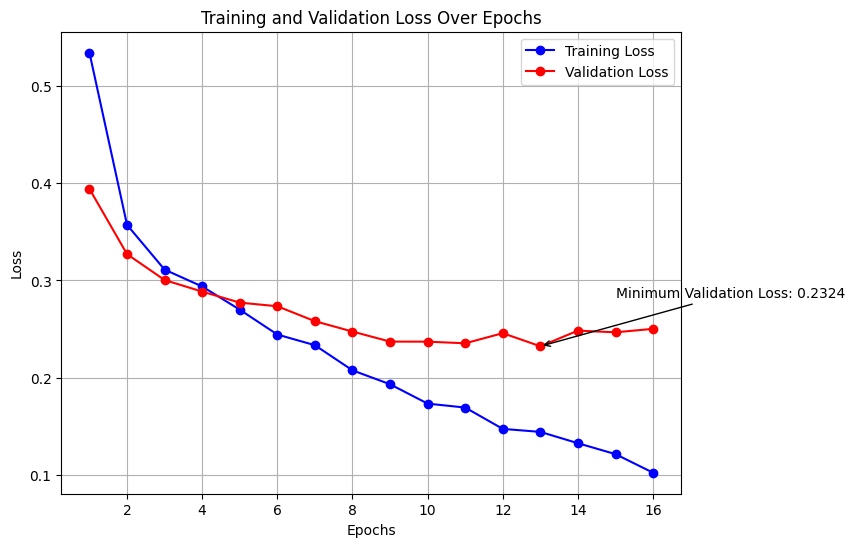

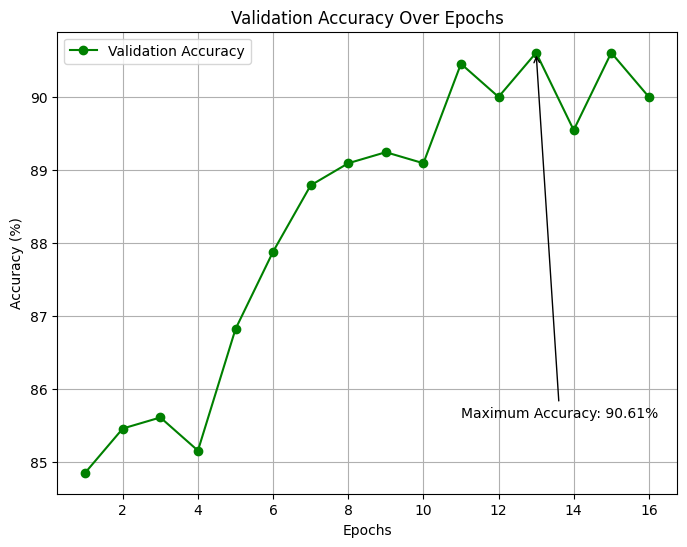

In [18]:
# Train the model
trained_model, train_losses, val_losses, accuracies = train_model(model, criterion, optimizer, train_loader, test_loader, epochs=20, patience=3)
plot_training_history(train_losses, val_losses, accuracies)

In [19]:
_, accuracy = validation(trained_model, criterion, test_loader)
print(f'Accuracy on test set: {accuracy:.2f}')

Accuracy on test set: 90.00
